In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import os, tqdm
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelBinarizer

import wandb
os.environ["WANDB_ENTITY"] = "c3-mcv"
wandb.login(key = '14a56ed86de5bf43e377d95d05458ca8f15f5017', relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Luis/.netrc


True

Let us first read the train and test files

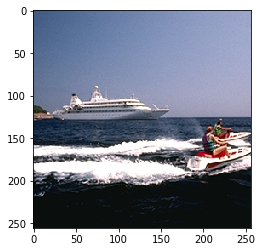

In [87]:
img = cv2.imread(r'./MIT_split/train/coast/arnat59.jpg')[:,:,::-1]
plt.imshow(img)

In [20]:
#utils functions
def histogram_intersection_kernel(X, Y):
    """
    Histogram intersection kernel.
    
    Args:
    X: array-like of shape (n_samples_X, n_features)
    Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
    kernel_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Expand dimensions of X and Y for broadcasting
    X_expanded = np.expand_dims(X, 1)
    Y_expanded = np.expand_dims(Y, 0)

    # Compute the minimum between each pair of vectors (broadcasting)
    minima = np.minimum(X_expanded, Y_expanded)

    # Sum over the feature dimension to compute the kernel
    kernel_matrix = np.sum(minima, axis=2)

    return kernel_matrix

def histogram_intersection_distance(X, Y):
    """
    Histogram intersection distance for kNN.
    
    Args:
    X: array-like of shape (n_samples_X, n_features)
    Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
    distance_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Calculate the histogram intersection similarity
    similarity = histogram_intersection_kernel(X, Y)
    
    max_similarity = np.minimum(X.sum(axis=1)[:, np.newaxis], Y.sum(axis=1)[np.newaxis, :])
    return 1 - (similarity / max_similarity)

def accuracy(predictions, labels):
    return sum(predictions == labels) / len(labels)

def precision(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fp = np.sum((predictions == class_label) & (labels != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fn = np.sum((predictions != class_label) & (labels == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def average_precision(predictions, labels):
    classes = np.unique(labels)
    return np.mean([precision(predictions, labels, c) for c in classes])

def average_recall(predictions, labels):
    classes = np.unique(labels)
    return np.mean([recall(predictions, labels, c) for c in classes])

def average_f1(predictions, labels):
    return 2 * average_precision(predictions, labels) * average_recall(predictions, labels) / (average_precision(predictions, labels) + average_recall(predictions, labels))

def compute_macro_roc_curve(y_onehot_test, y_score):
    """
    Computes the ROC curve and ROC area for each class.
    
    Args:
    y_onehot_test: array-like of shape (n_samples, n_classes)
    prob_matrix: array-like of shape (n_samples, n_classes)
    
    Returns:
    fpr: dict of false positive rates for each class
    tpr: dict of true positive rates for each class
    roc_auc: dict of ROC AUC values for each class
    """
    n_classes = y_onehot_test.shape[1]
    # store the fpr, tpr
    fpr, tpr = dict(), dict()
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    return fpr_grid, mean_tpr / n_classes

In [44]:
class BoVW():
    def __init__(self, config, size_per_class=1e9, preload_features=False, folder_path_train='./train', folder_path_test='./test'):

        self.config = config
        self.train_dataset = {'image_paths': [], 'labels': []}
        self.test_dataset = {'image_paths': [], 'labels': []}

        for label in os.listdir(folder_path_train):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_train, label))):
                self.train_dataset['image_paths'].append(os.path.join(folder_path_train, label, image_name))
                self.train_dataset['labels'].append(label)

                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.train_dataset['labels'] = np.array(self.train_dataset['labels'])
        for label in os.listdir(folder_path_test):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_test, label))):
                self.test_dataset['image_paths'].append(os.path.join(folder_path_test, label, image_name))
                self.test_dataset['labels'].append(label)
                
                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.test_dataset['labels'] = np.array(self.test_dataset['labels'])
        self.train_features, self.test_features = self._compute_descriptors(preload=preload_features)

        # Classification
        if self.config['classifier'] == 'knn':
            self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neigh'], n_jobs=-1, metric=self.config['metric'])
        elif self.config['classifier'] == 'svm':
            self.classifier = SVC(kernel = self.config['kernel'], degree=self.config['degree_pol'], gamma = 'auto', C = self.config['C'], probability=True, random_state=123)
        elif self.config['classifier'] == 'logistic':
            self.classifier = LogisticRegression(multi_class = 'auto', penalty='l2', solver='lbfgs', C = self.config['C'], n_jobs=-1, random_state=123)

        self.dim_red = None
        if self.config['n_components'] > 0:
            self.dim_red = PCA(n_components = self.config['n_components'])
        # if self.config['dimentionality_reduction'] == 'lda':
            # self.dim_red = LinearDiscriminantAnalysis(n_components = self.config['n_components'])

    def _compute_descriptors(self, preload=False):

        if preload:
            return ...
        
        # Initialize lists to store results
        features_train, features_test = [], []

        # Iterate over all files in the directory
        for i,dataset in enumerate([self.train_dataset['image_paths'], self.test_dataset['image_paths']]):
            for j,filename in enumerate(tqdm.tqdm(dataset, desc='Extracting features from dataset %d' % i)):
                # Load the imag
                img = cv2.imread(filename)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                if self.config['descriptor'] == 'dense_sift':
                    # Initialize Dense SIFT extractor
                    sift = cv2.SIFT_create()
                    kp = [cv2.KeyPoint(x, y, self.config['step_size']) for y in range(0, gray.shape[0], self.config['step_size'])
                                                                       for x in range(0, gray.shape[1], self.config['step_size'])]
                    kp, des = sift.compute(gray, kp)

                elif self.config['descriptor'] == 'sift':
                    # Initialize Dense SIFT extractor
                    sift = cv2.SIFT_create()
                    _, des = sift.detectAndCompute(gray, None)

                elif self.config['descriptor'] == 'akaze':
                    # Initialize AKAZE extractor
                    akaze = cv2.AKAZE_create()
                    _, des = akaze.detectAndCompute(gray, None)
                
                if i == 0:
                    features_train.append(des)
                else:
                    features_test.append(des)
        return np.array(features_train), np.array(features_test)
        

    def fit(self):
        self.kmeans = MiniBatchKMeans(n_clusters=self.config['n_words'], verbose=False, batch_size=1024, compute_labels=False, random_state=123)
        self.kmeans.fit(self.train_features.reshape(-1,128))

        self.visual_words_train = np.zeros((len(self.train_features), self.config['n_words']), dtype=int)
        for i in range(len(self.train_features)):
            words = self.kmeans.predict(self.train_features[i])
            self.visual_words_train[i,:] = np.bincount(words, minlength=self.config['n_words'])
    
        if self.dim_red is not None:
            self.visual_words_train = self.dim_red.fit_transform(self.visual_words_train)
        
         # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            self.visual_words_train_old = self.visual_words_train.copy()
            self.visual_words_train = histogram_intersection_distance(self.visual_words_train, self.visual_words_train)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            self.visual_words_train_old = self.visual_words_train.copy()
            self.visual_words_train = histogram_intersection_kernel(self.visual_words_train, self.visual_words_train)
            
        self.classifier.fit(self.visual_words_train, self.train_dataset['labels'])

    def predict(self):
        visual_words_test = np.zeros((len(self.test_features), self.config['n_words']), dtype=int)

        for i in range(len(self.test_features)):
            words = self.kmeans.predict(self.test_features[i])
            visual_words_test[i,:] = np.bincount(words, minlength=self.config['n_words'])
        
        if self.dim_red is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)

        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            visual_words_test = histogram_intersection_distance(visual_words_test, self.visual_words_train_old)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            visual_words_test = histogram_intersection_kernel(visual_words_test, self.visual_words_train_old)

        return self.classifier.predict(visual_words_test), self.classifier.predict_proba(visual_words_test)
    
    def fit_cross_validation(self):
        
        kf = KFold(n_splits=self.config['n_folds'], shuffle=True, random_state=123)
        predictions, y_scores, labels = [], [], []

        for train_index, test_index in tqdm.tqdm(kf.split(self.train_features), desc='Cross validation', total=self.config['n_folds']):
            # Split features and labels for this fold
            X_train, X_test = self.train_features[train_index], self.train_features[test_index]
            y_train, y_test = self.train_dataset['labels'][train_index], self.train_dataset['labels'][test_index]

            # Fit KMeans
            kmeans_cv = MiniBatchKMeans(n_clusters=self.config['n_words'], batch_size=1024, compute_labels=False, random_state=123)
            kmeans_cv.fit(X_train.reshape(-1,128))

            # Count train visual words
            visual_words_train = np.zeros((len(X_train), self.config['n_words']), dtype=int)
            for i in range(len(X_train)):
                words = kmeans_cv.predict(X_train[i])
                visual_words_train[i,:] = np.bincount(words, minlength=self.config['n_words'])
            
            # Dimensionality reduction
            if self.dim_red is not None:
                visual_words_train = self.dim_red.fit_transform(visual_words_train)

            # Compute distance/kenrel matrix
            if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
                visual_words_train_old = visual_words_train.copy()
                visual_words_train = histogram_intersection_distance(visual_words_train, visual_words_train)
            elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
                visual_words_train_old = visual_words_train.copy()
                visual_words_train = histogram_intersection_kernel(visual_words_train, visual_words_train)

            # Fit classifier
            self.classifier.fit(visual_words_train, y_train)
            
            # Predict
            visual_words_test = np.zeros((len(X_test), self.config['n_words']), dtype=int)

            #Count test visual words
            for i in range(len(X_test)):
                words = kmeans_cv.predict(X_test[i])
                visual_words_test[i,:] = np.bincount(words, minlength=self.config['n_words'])
                
            if self.dim_red is not None:
                visual_words_test = self.dim_red.transform(visual_words_test)
            
            # Compute distance/kenrel matrix
            if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
                visual_words_test = histogram_intersection_distance(visual_words_test, visual_words_train_old)
            elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
                visual_words_test = histogram_intersection_kernel(visual_words_test, visual_words_train_old)
            
            y_scores.append(self.classifier.predict_proba(visual_words_test))
            predictions.append(self.classifier.predict(visual_words_test))
            labels.append(y_test)

        return predictions, y_scores, labels
    

def log_metrics(config, predictions, y_scores, y_test):
    wandb.log({
        'accuracy': np.mean([accuracy(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_precision': np.mean([average_precision(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_recall': np.mean([average_recall(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_f1': np.mean([average_f1(predictions[i], y_test[i]) for i in range(len(predictions))]),
    })

    # ----------------- #
    #Log ROC curve
    n_folds = config['n_folds']
    result_roc = np.empty((n_folds, 1000))
    result_auc = []

    for n in range(n_folds):
        y_onehot_test = LabelBinarizer().fit_transform(y_test[n])
        fpr_grid, mean_tpr = compute_macro_roc_curve(y_onehot_test, y_scores[n])

        #Average it and compute AUC
        result_roc[n] = mean_tpr 
        result_auc.append(auc(fpr_grid, mean_tpr))

    plt.figure(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        result_roc.mean(axis=0),
        label=f"macro-average ROC curve (AUC = {np.mean(result_auc):.2f})",
        color="tab:blue",
        linestyle=":",
        linewidth=4,
    )

    # plot chance level
    plt.plot([0, 1], [0, 1], linestyle="--", color="black", linewidth=2, label="Chance")

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    wandb.log({f"Mean {n_folds}Fold-CV Macro-averaged One-vs-Rest ROC": plt})


def sweep_bovw():
    with wandb.init() as run:
        # Get hyperparameters
        config = run.config
        print(config)
        bovw = BoVW(config)
        predictions, y_scores, labels = bovw.fit_cross_validation()
        log_metrics(config, predictions, y_scores, labels)

# config = {
#     'descriptor': 'dense_sift', # CREC QUE LAKAZE NO FUNCIONARA PQ NO PODEM CONTROLAR EL NOMBRE DE LES FEATURES -> FALTA COMPROVAR
#     'step_size': 40,
#     'n_words': 128,
#     'n_neigh': 5,
#     'metric': 'euclidean',
#     'n_folds': 5,
#     'dimentionality_reduction': 'pca',
#     'n_components': 50,
#     'level_pyramid': 1,
#     'C':1,
#     'degree_pol': 3,
#     'kernel': 'rbf',
#     'classifier': 'logistic',
#     'fisher_vector': False
# }
# bovw = BoVW(config)#, size_per_class=50)
# bovw.fit()
# predictions = bovw.predict()
#bovw.fit_cross_validation()

# falta implentar las divisiones de la piramide
# falta implementar el fisher vector
# norm/scaler????

In [45]:
# 'n_neigh': {'distribution':'int_uniform', 'min': 1, 'max': 10}
# 'metric': {'values': ['euclidean', 'manhattan', 'cosine', 'precomputed]} # implement histogram intersection function distance

# Define the sweep for each classifier and each descriptor
sweep_configuration = {
    "method": "bayes",
    "name": "sweep-SVM-dense_sift",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        'classifier': {'value': 'svm'},
        'descriptor': {'value': 'dense_sift'},
        'n_folds': {'value': 10},
        'step_size': {'distribution':'int_uniform', 'min': 1, 'max': 100},
        'n_words': {'distribution':'int_uniform', 'min': 256, 'max': 1024},
        'level_pyramid': {'distribution':'int_uniform', 'min': 1, 'max': 4},
        'n_components': {'distribution':'int_uniform', 'min': 0, 'max': 256},
        'kernel': {'values': ['rbf', 'linear', 'poly', 'precomputed']},
        'degree_pol': {'distribution':'int_uniform', 'min': 2, 'max': 5},
        'C': {'values': [0.001, 0.01, 0.1, 1, 10, 100]},
        'fisher_vector': {'values': [True, False]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="bovw", entity="c3-mcv") # EJECUTAR UNA VEZ POR CLASIFICADOR Y DESCRIPTOR

Create sweep with ID: t3fzx1bn
Sweep URL: https://wandb.ai/c3-mcv/bovw/sweeps/t3fzx1bn


In [46]:
wandb.agent('t3fzx1bn', function=sweep_bovw, count=3)

wandb: Agent Starting Run: j2vz0pkm with config:
wandb: 	C: 0.01
wandb: 	classifier: svm
wandb: 	degree_pol: 4
wandb: 	descriptor: dense_sift
wandb: 	fisher_vector: False
wandb: 	kernel: linear
wandb: 	level_pyramid: 1
wandb: 	n_components: 77
wandb: 	n_folds: 10
wandb: 	n_words: 519
wandb: 	step_size: 82
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


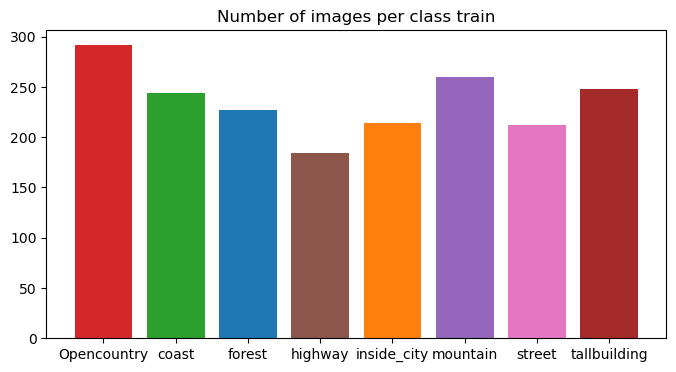

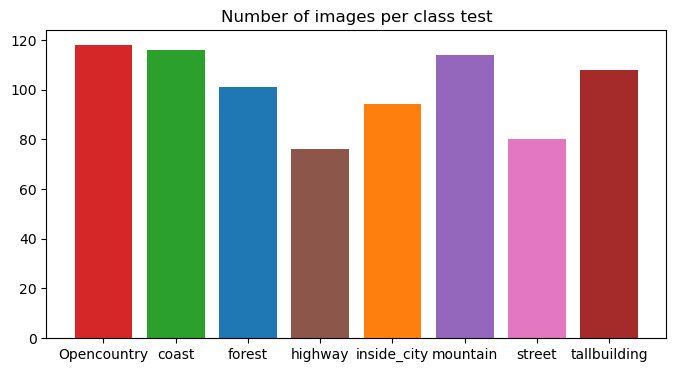

In [27]:
# Checking imbalance
# Create a bar plot counting the number of images per class
colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]

unique, counts = np.unique(bovw.train_dataset['labels'], return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(unique, counts, color=colors)
plt.title('Number of images per class train')
plt.show()

# Create a bar plot counting the number of images per class
unique, counts = np.unique(bovw.test_dataset['labels'], return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(unique, counts, color=colors)
plt.title('Number of images per class test')
plt.show()


In [30]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

58.48822800495663


In [ ]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)